# Flat Clustering

In this notebook, you will get familiar with two flat clustering methods: k-means and EM clustering.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data: iris flowers

We start by clustering a small dataset: the iris flowers dataset. This dataset consists of four attributes which describe the properties of a set of iris flowers. Each flower is labeled with its type, or *species*. There are three different species in the dataset: Iris setosa, Iris versicolor and Iris virginica.

In [2]:
data = pd.read_csv('../datasets/iris.csv')
data.head()

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Note that, as opposed to classification, clustering is an unsupervised task. Therefore, we remove the class label from data, such that is unknown to the clustering methods.

In [3]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X.head()

,sepallength,sepalwidth,petallength,petalwidth
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## Implementing k-means clustering

**Exercise 1:** Implement the k-means algorithm as you have seen it in the lectures, using the Euclidean distance. Your implementation should take two parameters: the number of clusters and the maximal number of iterations. Initialize the cluster centroids by randomply sampling points from the given dataset.

In [4]:
def k_means(X, n_clusters=3, max_iter=1000):
    """
    Cluster the data `X` using k-means.
    
    Parameters
    ----------
    X : pd.DataFrame
        Input data.
    n_clusters : int
        The number of clusters. Default: 3
    max_iter : int
        Maximal number of iterations. Default: 100
    """

    # Use k random points of X as initial cluster centroids
    centroids = pd.DataFrame(index=np.arange(n_clusters), columns=X.columns)
    r = np.random.choice(X.index, size=n_clusters, replace=False)
    for c in centroids.index:
        centroids.loc[c, :] = X.loc[r[c], :]
    
    # Iteratively assign points to k clusters
    assignments = None    
    for _ in range(max_iter):
        
        # Update cluster assignments: assign each point to cluster with closest centroid
        new_assignments = pd.Series(index=X.index)
        for i in X.index:
            new_assignments.loc[i] = closest_centroid(X.iloc[i], centroids)
        
        # If the cluster assignments did not change: stop
        if (assignments is not None) and all(new_assignments == assignments):
            break
        
        # Otherwise, continue and calculate new centroids
        assignments = new_assignments
        for c in centroids.index:
            centroids.loc[c, :] = np.mean(X.loc[assignments == c].values, axis=0)
    
    return assignments

def closest_centroid(x, centroids):
    """Find the cluster centroid that has the smallest Euclidean distance to point x."""
    distances = [np.linalg.norm(x.values - centroids.loc[c, :].values) for c in centroids.index]
    return distances.index(min(distances))

**Exercise 2:** Run your implementation of k-means clustering on this dataset and choose an appropriate number of clusters by visualizing the clusters.

Hint: you can use the <a href="https://seaborn.pydata.org/generated/seaborn.pairplot.html">`pairplot`</a> function of `seaborn` to plot a grid of all attribute pairs.

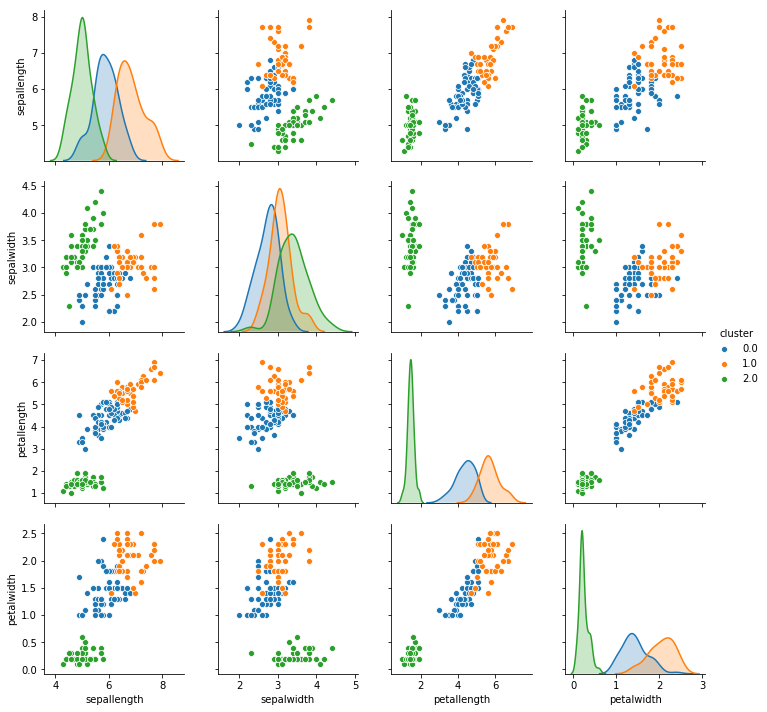

In [5]:
clusters = k_means(X, n_clusters=3)

data = X.copy()
data['cluster'] = clusters
sns.pairplot(data=data, vars=X.columns, hue='cluster')
plt.show()

Even though class labels are typically not given in clustering problems, it would be interesting for this dataset to check whether the clusters that we found using k-means actually correspond the species of the flowers. However, we cannot compare the assigned clusters with the class labels directly by computing e.g. the accuracy score as we did for evaluating classifiers.

**Question:** Why can we not simply compute the accuracy score?

**Exercise 3:** Look for a <a href="https://scikit-learn.org/stable/modules/classes.html#clustering-metrics">metric</a> that tells you how well the clusters correspond with the class labels. Compare the clusters to the given actual labels.

In [6]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(clusters, y)

0.7163421126838475

## EM clustering

Now, we will try to improve this score by using a different clustering algorithm. By looking at the plots that visualize the k-means clusters, we can see that two of the clusters are close to each other. The data points close to this boundary may therefore be assigned to the wrong cluster. Let's instead try a different clustering method based on the expectation-maximization algorithm (look for `GaussianMixture` in the `scikit-learn` documentation).

**Exercise 4:** Cluster the Iris flowers using the algorithm described above. Visualize the clusters again and compare the correspondence to the class labels with the k-means algorithm. Does this method result in a better clustering?

0.9038742317748124


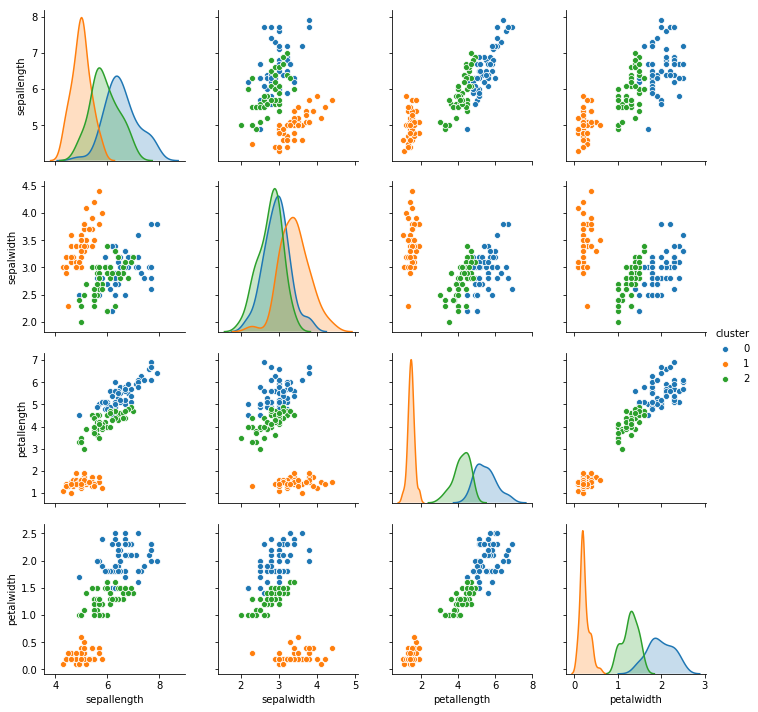

In [7]:
from sklearn.mixture import GaussianMixture

em = GaussianMixture(n_components=3)
clusters = em.fit_predict(X)

print(adjusted_rand_score(clusters, y))

data = X.copy()
data['cluster'] = clusters
sns.pairplot(data=data, vars=X.columns, hue='cluster')
plt.show()

## Clustering images

Let's proceed with a more interesting dataset. Instead of iris flowers, we will now cluster images of famous football players. For this, you will need some additional packages. Make sure you've installed the packages listed below:

In [ ]:
!pip install opencv-python
!pip install face_recognition
!pip install imutils

In [8]:
import cv2
import face_recognition
from imutils import paths

### Feature extraction

Instead of using the raw pixels of the images directly, we first cut out the faces from the images and extract a feature vector representation from each face. As this is not the goal of this exercise, the code for doing this step is given:

In [ ]:
dir = '../datasets/images'
data = []
for i, path in enumerate(paths.list_images(dir)):
    print(path)
    # Load the images
    rgb = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    # Find the bounding boxes of the faces
    boxes = face_recognition.face_locations(rgb, model='cnn')
    # Encode the faces
    encodings = face_recognition.face_encodings(rgb, boxes)
    # Add to the dataset
    data.extend([
        {'path': path, 'rgb': rgb, 'box': box, 'encoding': encoding}
        for (box, encoding) in zip(boxes, encodings)
    ])
    
X = pd.DataFrame([d['encoding'] for d in data])
data = pd.DataFrame(data)

If the cell above runs too slow, you can also load the results: (this requires installing the `tables` package)

In [9]:
data = pd.read_hdf('images.hdf', key='images')
X = pd.DataFrame([data.loc[i, 'encoding'] for i in data.index])

### Visualization

Whereas we only had four attributes in the Iris dataset, we now have a much larger number of features which makes it hard to visualize the data points. Instead we can project the points to a two-dimensional plane using a dimensionality reduction method. A commonly used reduction method is the <a href="https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding">*t-distributed stochastic neighbor embedding*</a> or t-SNE in short, which is also implemented in `scikit-learn`.

**Exercise 5:** Visualize a two-dimensional <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html">t-SNE</a> representation of the encodings. 

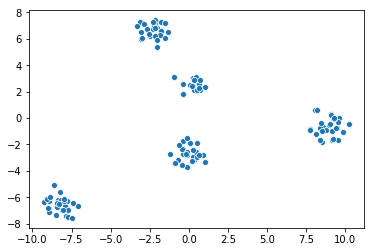

In [10]:
from sklearn.manifold import TSNE
X2D = TSNE(n_components=2).fit_transform(X)
sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1])
plt.show()

### Clustering

**Exercise 6:** Use your k-means implementation to cluster the images (using the t-SNE representation as input data)

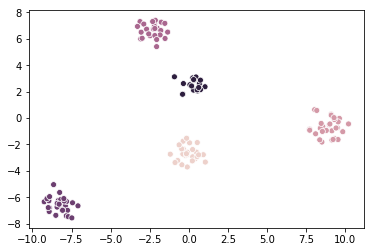

In [11]:
clusters = k_means(X, n_clusters=5)
sns.scatterplot(x=X2D[:, 0], y=X2D[:, 1], hue=clusters, legend=False)
plt.show()

**Exercise 7:** Do the clusters actually make sense? Plot the images of their correspoding faces.

Cluster 1.0


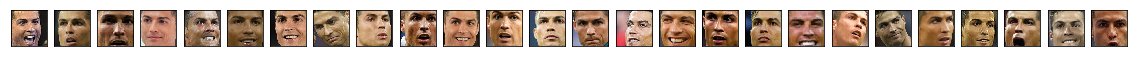

Cluster 2.0


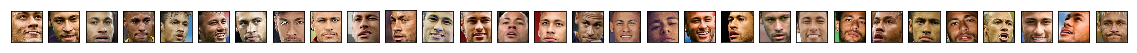

Cluster 3.0


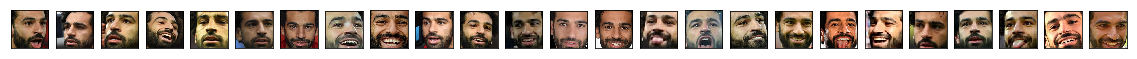

Cluster 4.0


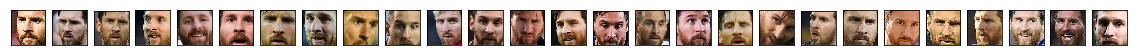

Cluster 5.0


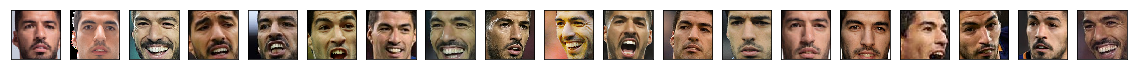

In [12]:
for c in sorted(np.unique(clusters[clusters>=0])):
    print("Cluster {}".format(c + 1))
    indexes = [i for i in range(len(data)) if clusters[i] == c]
    plt.figure(figsize=(20, 2))
    for i, idx in enumerate(indexes):
        top, right, bottom, left = data.loc[idx, 'box']
        face = data.loc[idx, 'rgb'][top:bottom, left:right]
        plt.subplot(1, len(indexes), i + 1)
        plt.imshow(face)
        plt.xticks([])
        plt.yticks([])
    plt.show()